In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [34]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import pystan
import re
from scipy.interpolate import interp1d
import seaborn as sns
from true_params import true_params

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

In [3]:
samples = {}
with h5py.File('observations.h5', 'r') as f:
    nobs, Tobs = f.attrs['1yr']
    nobs = int(round(nobs))
    for k in ['m1det', 'm2det', 'dl', 'log_m1m2dl_prior']:
        samples[k] = array(f['posteriors'][k])
    nsamp = array(f['posteriors']['nsamp'], dtype=np.int)
m1s = []
m2s = []
dls = []
log_prs = []

for i in range(nobs):
    sel = random.choice(samples['m1det'][i,:].shape[0], nsamp[i], replace=False)
    m1s.append(samples['m1det'][i,sel])
    m2s.append(samples['m2det'][i,sel])
    dls.append(samples['dl'][i,sel])
    log_prs.append(samples['log_m1m2dl_prior'][i,sel])
m1s = concatenate(m1s)
m2s = concatenate(m2s)
dls = concatenate(dls)
log_prs = concatenate(log_prs)

In [4]:
sel = {}
nsel = 262144

with h5py.File('selected.h5', 'r') as f:
    s = random.choice(f['m1det'].shape[0], nsel, replace=False)
    sel['m1det'] = array(f['m1det'])[s]
    sel['m2det'] = array(f['m2det'])[s]
    sel['dldet'] = array(f['dl'])[s]
    sel['wtdet'] = array(f['wt'])[s]
    sel['N_gen'] = int(round(float(f.attrs['N_gen'])*nsel/float(len(f['m1det']))))

In [5]:
ninterp = 500
zMax = 10
zinterp = expm1(linspace(log(1), log(zMax+1), ninterp))

mnorm = exp(arange(log(1), log(400), 0.01))
nnorm = len(mnorm)

In [6]:
d = {
    'nobs': nobs,
    'nsel': nsel,
    'ninterp': ninterp,
    'nnorm': nnorm,
    
    'nsamp': nsamp[:nobs],
    'nsamp_total': np.sum(nsamp[:nobs]),
    
    'Tobs': Tobs,
    'N_gen': sel['N_gen'],
    
    'm1obs': m1s,
    'm2obs': m2s,
    'dlobs': dls,
    'log_samp_wts': log_prs,
    
    'm1sel': sel['m1det'],
    'm2sel': sel['m2det'],
    'dlsel': sel['dldet'],
    'wtsel': sel['wtdet'],
    
    'zinterp': zinterp,
    
    'ms_norm': mnorm,
    
    'use_cosmo_prior': 0,
    'mu_H0': Planck15.H0.to(u.km/u.s/u.Mpc).value,
    'sigma_H0': 0.01*Planck15.H0.to(u.km/u.s/u.Mpc).value,
    'mu_Omh2': 0.02225+0.1198,
    'sigma_Omh2': sqrt(0.00016**2 + 0.0015**2)
}

In [7]:
model = pystan.StanModel(file='model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd491f29d8b4ce6b335a05b26e2ddc24 NOW.


In [42]:
r = model.vb(data=d, output_samples=4000)

In [43]:
class VBResultProxy(object):
    def __init__(self, vbres):
        self._vbres = vbres
    @property
    def res(self):
        return self._vbres
    def __getitem__(self, x):
        if x + '[1]' in self.res['sampler_param_names']:
            # Then it's an array:
            i = 1
            cols = []
            while True:
                if x + '[{:d}]'.format(i) in self.res['sampler_param_names']:
                    cols.append(self.res['sampler_params'][self.res['sampler_param_names'].index(x+'[{:d}]'.format(i))])
                    i = i+1
                else:
                    break
            return np.column_stack(cols)
        elif not x in self.res['sampler_param_names']:
            # Parameter not found
            raise ValueError('key not found in sampler params:', x)
        else:
            # It's a scalar
            return self.res['sampler_params'][self.res['sampler_param_names'].index(x)]

In [44]:
p = VBResultProxy(r)

/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


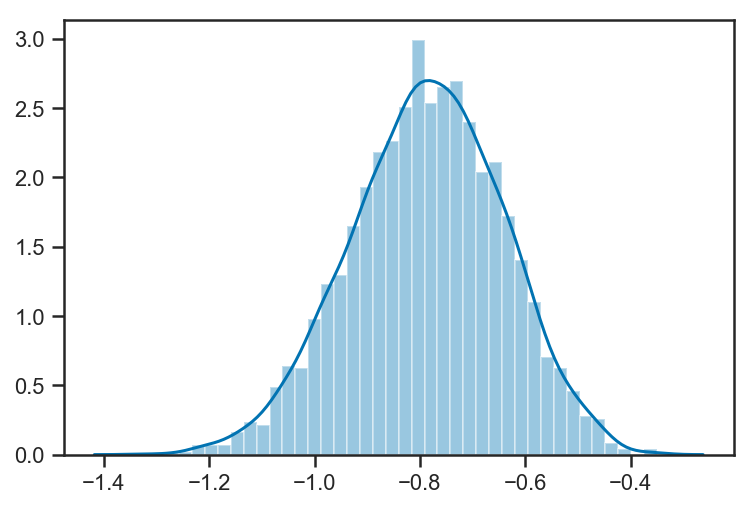

In [45]:
sns.distplot(p['w'])

In [48]:
nobs = len(m1s)
ndet = nsel
with h5py.File('population_1yr.h5', 'w') as out:
    out.attrs['nobs'] = nobs
    out.attrs['nsel'] = ndet

    for n in ['H0', 'Om', 'w', 'R0', 'MMin', 'MMax', 'sigma_low', 'sigma_high', 'alpha', 'beta', 'gamma', 'Nex', 'neff_det', 'neff', 'm1_source', 'm2_source', 'dl_source', 'z_source']:
        d = array(p[n])
        if len(d.shape) == 1:
            d = reshape(d, (4, -1))
        else:
            d = reshape(d, (4, -1, d.shape[-1]))
        out.create_dataset(n, data=p[n], compression='gzip', shuffle=True)